In [19]:

import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import dateutil
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 4)

data_dir='/Users/abertran/Documents/Data/MLClass/'


#Read app cpu data
file_name='agg_application_pod_hourly.csv'
df=pd.read_csv(data_dir+file_name, header=None, na_values=[r'\N'])
df.columns = ['hour_key', 'date_key','datacenter','superpod','pod','mem_utilization','max_app_cpu','avg_app_cpu','gc_perc','p95_app_cpu','last_modified','app_host_count_active','app_transacting_host_count']

df['hour_key']=df['hour_key'].astype('str')
df['date_key']=df['date_key'].astype('str')
df['hour_date']=df['date_key']+ " " + df["hour_key"] + ":00"
df_timestamp = [dateutil.parser.parse(a) for a in df['hour_date'].tolist()]
df['Timestamp'] = df_timestamp

#The columns you want here are hour_key, date_key, datacenter, superpod, pod and avg_app_cpu
df = df[['Timestamp','datacenter','superpod','pod','mem_utilization','max_app_cpu','avg_app_cpu','gc_perc','p95_app_cpu']]

df.head()

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


,Timestamp,datacenter,superpod,pod,mem_utilization,max_app_cpu,avg_app_cpu,gc_perc,p95_app_cpu
0,2017-01-21 07:00:00,LON,SP9,cs86,37.980300,7.938677,5.929535,0.799236,NaN
1,2017-01-21 07:00:00,WAS,SP2,na4,69.257324,14.353811,11.269566,0.910468,NaN
2,2017-01-21 07:00:00,CHI,SP1,gs0,33.341110,17.466251,10.286361,1.259740,NaN
3,2017-01-21 07:00:00,CHI,SP3,cs23,62.849570,13.417571,9.052662,0.980685,NaN
4,2017-01-21 07:00:00,LON,SP9,cs87,34.985798,7.711010,5.902223,0.510657,NaN


In [20]:
df.dtypes

Timestamp          datetime64[ns]
datacenter                 object
superpod                   object
pod                        object
mem_utilization           float64
max_app_cpu               float64
avg_app_cpu               float64
gc_perc                   float64
p95_app_cpu               float64
dtype: object

Let's look at data for a particular pod

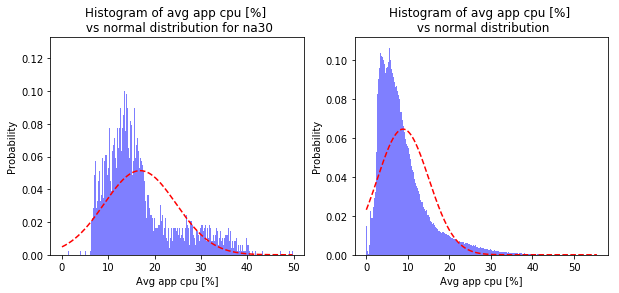

In [21]:
interested_pod="na30"
mask = (df['pod'] == interested_pod)
df_model = df.loc[mask]
df_model=df_model.sort_values(by=['Timestamp'])


fig, axes = plt.subplots(nrows=1, ncols=2)
ax0, ax1 = axes.flatten()
n, bins, patches = ax0.hist(df_model['avg_app_cpu'].dropna(),1000,normed=1, facecolor='blue', alpha=0.5)#, 100, normed=1, facecolor='blue', alpha=0.5
mu = np.mean(df_model['avg_app_cpu'].dropna())
sigma = np.std(df_model['avg_app_cpu'].dropna())
y = mlab.normpdf(bins, mu, sigma)
#plt.subplot(1, 2, 1)
ax0.plot(bins, y, 'r--')
ax0.set_xlabel('Avg app cpu [%]')
ax0.set_ylabel('Probability')
ax0.set_title('Histogram of avg app cpu [%] \n vs normal distribution for '+interested_pod)
#plt.show()
n, bins, patches = ax1.hist(df['avg_app_cpu'].dropna(),1000,normed=1, facecolor='blue', alpha=0.5)#, 100, normed=1, facecolor='blue', alpha=0.5
mu = np.mean(df['avg_app_cpu'].dropna())
sigma = np.std(df['avg_app_cpu'].dropna())
y = mlab.normpdf(bins, mu, sigma)
#plt.subplot(1, 2, 2)
ax1.plot(bins, y, 'r--')
ax1.set_xlabel('Avg app cpu [%]')
ax1.set_ylabel('Probability')
ax1.set_title('Histogram of avg app cpu [%] \n vs normal distribution')
plt.show()

#(min(df['avg_app_cpu']),max(df['avg_app_cpu']))

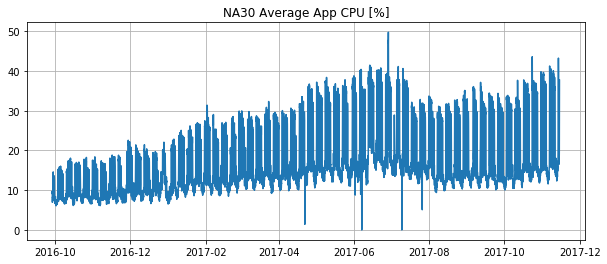

In [22]:
plt.plot(df_model['Timestamp'],df_model['avg_app_cpu'])
plt.title('NA30 Average App CPU [%]')
plt.grid(True)
plt.show()

Around 2017-06-22 there was a remediation, for our model let's grab 6 months worth of data before the remediation to see how our prediction does.

In [23]:
mask= (df_model['Timestamp'] < dateutil.parser.parse('2017-6-22')) & (df_model['Timestamp'] > dateutil.parser.parse('2016-12-22'))
df_model = df_model[mask]

In [24]:
training_data_length=int(np.round(0.80*df_model.shape[0]))

df_model_train = df_model[0:training_data_length]
df_model_test=df_model[training_data_length:]

In [25]:


df_model_train['indices'] = (df_model_train['Timestamp']-df_model_train['Timestamp'].iloc[0]).astype('timedelta64[h]')
df_model_test['indices'] = (df_model_test['Timestamp']-df_model_train['Timestamp'].iloc[0]).astype('timedelta64[h]')


###Possibly remove this code?
from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.formula.api as smf
mod = smf.quantreg('avg_app_cpu ~ indices', df_model_train)
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(, df_model['avg_app_cpu'], random_state=0)

#Median regression
res = mod.fit(q=.5)
print(res.summary())

#90P regression
res = mod.fit(q=.9)
print(res.summary())
###End of Possibly remove this code?


#Install rpy2 - need to install R3.3 then pip install rpy2



                         QuantReg Regression Results                          
Dep. Variable:            avg_app_cpu   Pseudo R-squared:              0.05995
Model:                       QuantReg   Bandwidth:                       2.023
Method:                 Least Squares   Sparsity:                        10.20
Date:                Wed, 13 Dec 2017   No. Observations:                 3484
Time:                        14:07:59   Df Residuals:                     3482
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.0547      0.173     63.984      0.000      10.716      11.393
indices        0.0017   8.58e-05     19.394      0.000       0.001       0.002

The condition number is large, 4.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [26]:
#Install R and rpy2

#Quantile regression

import rpy2;
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
#import pandas.rpy.common as com
#rdf_model_train = com.convert_to_r_dataframe(df_model_train)
rdf_model_train = pandas2ri.py2ri(df_model_train[['indices','avg_app_cpu']])
#rdf_model_test = pandas2ri.py2ri(df_model_test[['indices','avg_app_cpu']])
indices_to_forecast_r = pandas2ri.py2ri(df_model_test[['indices']])


quantreg = importr('quantreg')

robjects.r('''
           med_coeff <- function(train) {
                    library(quantreg)
                    train1.rf <- rq(avg_app_cpu ~ indices, data = train, tau=0.5)
            }
            ''')
robjects.r('''
           ninetyp_coeff <- function(train) {
                    library(quantreg)
                    train1.rf <- rq(avg_app_cpu ~ indices, data = train, tau=0.9)
            }
            ''')

#Predict
robjects.r('''
           g <- function(model,indices_to_forecast) {
                    pred=predict(model,data.frame(index=indices_to_forecast),interval="confidence")
                    #pred <- as.data.frame(predict(model, test))
                    pred = as.data.frame(pred)

            }
            ''')

#Model and forecast for 50percentile (median) quantile
r_f = robjects.globalenv['med_coeff']
rf_model=(r_f(rdf_model_train))
type(rf_model)
med_coeff=(np.array(rf_model.rx('coefficients'))).flatten()

r_g = robjects.globalenv['g']
pred_median=pandas2ri.ri2py(r_g(rf_model,indices_to_forecast_r))

#pred_median['indices'] = pd.Series((df_model_test['indices']).values, index=pred.index)

#Model and forecast for 90percentile quantile
r_f = robjects.globalenv['ninetyp_coeff']
rf_model=(r_f(rdf_model_train))
ninetyp_coeff=(np.array(rf_model.rx('coefficients'))).flatten()


r_g = robjects.globalenv['g']
pred_ninetyp=pandas2ri.ri2py(r_g(rf_model,indices_to_forecast_r))
#pred['indices']=df_model_test['indices']
type(pred_ninetyp)

#pred_ninetyp['indices'] = pd.Series((df_model_test['indices']).values, index=pred.index)
#Translate indices to Date

pred_ninetyp.head(10)

,fit,lower,higher
614433,33.797347,33.285195,34.309500
614578,33.801415,33.289025,34.313805
614642,33.805484,33.292856,34.318111
614789,33.809552,33.296687,34.322416
614937,33.813620,33.300518,34.326721
615083,33.817688,33.304349,34.331027
615147,33.821756,33.308180,34.335332
615295,33.825824,33.312010,34.339638
615440,33.829892,33.315841,34.343943
615579,33.833960,33.319671,34.348249


In [27]:
#Set-up the model quantile lines
x_start_med_line=df_model_train.iloc[0]['Timestamp']
x_end_med_line=df_model_train.iloc[(len(df_model_train)-1)]['Timestamp']
y_start_med_line=med_coeff[0]+med_coeff[1]*df_model_train.iloc[0]['indices']
y_end_med_line=med_coeff[0]+med_coeff[1]*df_model_train.iloc[(len(df_model_train)-1)]['indices']
y_start_extrap_line=ninetyp_coeff[0]+ninetyp_coeff[1]*df_model_train.iloc[0]['indices']
y_end_extrap_line=ninetyp_coeff[0]+ninetyp_coeff[1]*df_model_train.iloc[(len(df_model_train)-1)]['indices']

In [28]:
#Set-up the forecast quantile lines
x_forecast_start_med_line=df_model_test.iloc[0]['Timestamp']
x_forecast_end_med_line=df_model_test.iloc[(len(df_model_test)-1)]['Timestamp']
y_forecast_start_med_line=med_coeff[0]+med_coeff[1]*df_model_test.iloc[0]['indices']
y_forecast_end_med_line=med_coeff[0]+med_coeff[1]*df_model_test.iloc[(len(df_model_test)-1)]['indices']
y_forecast_start_extrap_line=ninetyp_coeff[0]+ninetyp_coeff[1]*df_model_test.iloc[0]['indices']
y_forecast_end_extrap_line=ninetyp_coeff[0]+ninetyp_coeff[1]*df_model_test.iloc[(len(df_model_test)-1)]['indices']

#Set-up the confidence interval for the forecast quantile lines
#50P
y_forecast_start_extrap_lwr_med=pred_median.iloc[0]['lower']
y_forecast_start_extrap_hghr_med=pred_median.iloc[0]['higher']
y_forecast_end_extrap_lwr_med=pred_median.iloc[(len(df_model_test)-1)]['lower']
y_forecast_end_extrap_hghr_med=pred_median.iloc[(len(df_model_test)-1)]['higher']
#90P
y_forecast_start_extrap_lwr_ninetyp=pred_ninetyp.iloc[0]['lower']
y_forecast_start_extrap_hghr_ninetyp=pred_ninetyp.iloc[0]['higher']
y_forecast_end_extrap_lwr_ninetyp=pred_ninetyp.iloc[(len(df_model_test)-1)]['lower']
y_forecast_end_extrap_hghr_ninetyp=pred_ninetyp.iloc[(len(df_model_test)-1)]['higher']

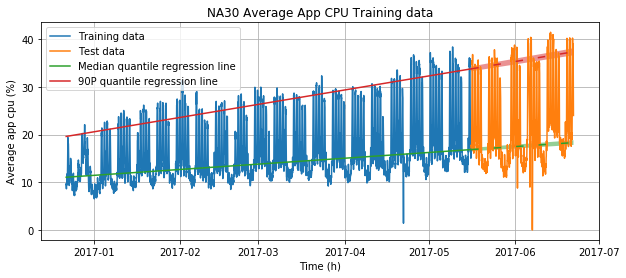

In [29]:
plt.plot(df_model_train['Timestamp'],df_model_train['avg_app_cpu'],c='#1f77b4')
plt.plot(df_model_test['Timestamp'],df_model_test['avg_app_cpu'],c='#ff7f0e')
plt.plot([x_start_med_line,x_end_med_line],[y_start_med_line,y_end_med_line],c='#2ca02c')
plt.plot([x_start_med_line,x_end_med_line],[y_start_extrap_line,y_end_extrap_line],c='#d62728')
plt.plot([x_forecast_start_med_line,x_forecast_end_med_line],[y_forecast_start_med_line,y_forecast_end_med_line],c='#2ca02c', linestyle='--', dashes=(5, 10))
plt.plot([x_forecast_start_med_line,x_forecast_end_med_line],[y_forecast_start_extrap_line,y_forecast_end_extrap_line],c='#d62728', linestyle='--', dashes=(5, 10))
#Bounds
plt.fill_between([x_forecast_start_med_line,x_forecast_end_med_line],[y_forecast_start_extrap_lwr_med,y_forecast_end_extrap_lwr_med],[y_forecast_start_extrap_hghr_med,y_forecast_end_extrap_hghr_med], facecolor='#2ca02c', alpha=0.5)
plt.fill_between([x_forecast_start_med_line,x_forecast_end_med_line],[y_forecast_start_extrap_lwr_ninetyp,y_forecast_end_extrap_lwr_ninetyp],[y_forecast_start_extrap_hghr_ninetyp,y_forecast_end_extrap_hghr_ninetyp], facecolor='#d62728', alpha=0.5)
plt.title('NA30 Average App CPU Training data')
plt.xlabel('Time (h)')
plt.ylabel('Average app cpu (%)')
plt.legend(['Training data','Test data','Median quantile regression line', '90P quantile regression line'])
plt.grid(True)
plt.show()

Let's measure the goodness of fit. 
Since we are doing quantile regression we can compare the fit to the quantiles of the data.

In [30]:
test=pd.rolling_quantile(df_model_test['avg_app_cpu'],24*7,0.9)
df_temp=df_model_test.copy(deep=True)
df_temp.set_index('Timestamp',inplace=True)
df_model_test_equantile=df_temp['avg_app_cpu'].groupby(pd.TimeGrouper(freq='W')).quantile(0.9)

df_temp=df_model_train.copy(deep=True)
df_temp.set_index('Timestamp',inplace=True)
df_model_train_equantile=df_temp['avg_app_cpu'].groupby(pd.TimeGrouper(freq='W')).quantile(0.9)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_quantile is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=168,center=False).quantile(quantile=0.9)
  """Entry point for launching an IPython kernel.


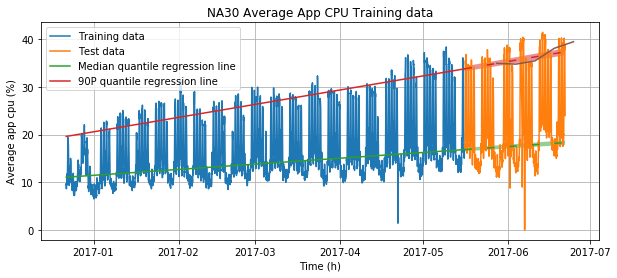

In [32]:
plt.plot(df_model_train['Timestamp'],df_model_train['avg_app_cpu'],c='#1f77b4')
plt.plot(df_model_test['Timestamp'],df_model_test['avg_app_cpu'],c='#ff7f0e')
plt.plot([x_start_med_line,x_end_med_line],[y_start_med_line,y_end_med_line],c='#2ca02c')
plt.plot([x_start_med_line,x_end_med_line],[y_start_extrap_line,y_end_extrap_line],c='#d62728')
plt.plot([x_forecast_start_med_line,x_forecast_end_med_line],[y_forecast_start_med_line,y_forecast_end_med_line],c='#2ca02c', linestyle='--', dashes=(5, 10))
plt.plot([x_forecast_start_med_line,x_forecast_end_med_line],[y_forecast_start_extrap_line,y_forecast_end_extrap_line],c='#d62728', linestyle='--', dashes=(5, 10))
#Bounds
plt.fill_between([x_forecast_start_med_line,x_forecast_end_med_line],[y_forecast_start_extrap_lwr_med,y_forecast_end_extrap_lwr_med],[y_forecast_start_extrap_hghr_med,y_forecast_end_extrap_hghr_med], facecolor='#2ca02c', alpha=0.5)
plt.fill_between([x_forecast_start_med_line,x_forecast_end_med_line],[y_forecast_start_extrap_lwr_ninetyp,y_forecast_end_extrap_lwr_ninetyp],[y_forecast_start_extrap_hghr_ninetyp,y_forecast_end_extrap_hghr_ninetyp], facecolor='#d62728', alpha=0.5)
#Upper bound
#plt.plot([x_forecast_start_med_line,x_forecast_end_med_line],c='#2ca02c', linestyle='--', dashes=(5, 10))

#plt.plot(df_model_test['Timestamp'],test,c='#7f7f7f')
plt.plot(df_model_test_equantile.index.values[1:],df_model_test_equantile[1:],c='#8c564b')
plt.title('NA30 Average App CPU Training data')
plt.xlabel('Time (h)')
plt.ylabel('Average app cpu (%)')
plt.legend(['Training data','Test data','Median quantile regression line', '90P quantile regression line'])
plt.grid(True)
plt.show()


If we were to take more than 6 months of data, the prediction would be consistently below the actual because quantile regression uses a linear fit and the actual data, specially at the beginning of a pod's life, has a non-linear increase. This can be overcome by using feedback into the system as we observe the slope increasing over time.

Let's look at the traditional errors by comparing to the actual quantiles.

In [94]:
df_model_train_equantile_df = pd.DataFrame(df_model_train_equantile)
df_model_train_equantile_df.reset_index(level=0, inplace=True)
df_model_train_equantile_df=df_model_train_equantile_df.iloc[1:len(df_model_train_equantile_df)]

df_model_train_equantile_df['indices'] = (df_model_train_equantile_df['Timestamp']-df_model_train['Timestamp'].iloc[0]).astype('timedelta64[h]')
df_model_train_equantile_df['avg_app_cpu_pred']=ninetyp_coeff[0]+ninetyp_coeff[1]*df_model_train_equantile_df['indices']
rms_train=np.sqrt(np.mean(np.square(df_model_train_equantile_df['avg_app_cpu_pred']-df_model_train_equantile_df['avg_app_cpu'])))
MAE_train=(1/len(df_model_train_equantile_df))*np.sum(np.abs(df_model_train_equantile_df['avg_app_cpu_pred']-df_model_train_equantile_df['avg_app_cpu']))
MAPE_train=(100/len(df_model_train_equantile_df))*np.sum(np.abs(df_model_train_equantile_df['avg_app_cpu_pred']-df_model_train_equantile_df['avg_app_cpu'])/df_model_train_equantile_df['avg_app_cpu'])


df_model_test_equantile_df = pd.DataFrame(df_model_test_equantile)
df_model_test_equantile_df.reset_index(level=0, inplace=True)
df_model_test_equantile_df=df_model_test_equantile_df.iloc[1:len(df_model_test_equantile)]

df_model_test_equantile_df['indices'] = (df_model_test_equantile_df['Timestamp']-df_model_train['Timestamp'].iloc[0]).astype('timedelta64[h]')
df_model_test_equantile_df['avg_app_cpu_pred']=ninetyp_coeff[0]+ninetyp_coeff[1]*df_model_test_equantile_df['indices']
rms_test=np.sqrt(np.mean(np.square(df_model_test_equantile_df['avg_app_cpu_pred']-df_model_test_equantile_df['avg_app_cpu'])))
MAE_test=(1/len(df_model_test_equantile_df))*np.sum(np.abs(df_model_test_equantile_df['avg_app_cpu_pred']-df_model_test_equantile_df['avg_app_cpu']))
MAPE_test=(100/len(df_model_test_equantile_df))*np.sum(np.abs(df_model_test_equantile_df['avg_app_cpu_pred']-df_model_test_equantile_df['avg_app_cpu'])/df_model_test_equantile_df['avg_app_cpu'])

print('RMS error for train set: ' + str(np.round(rms_train, decimals=2)) + '% app cpu')
print('RMS error for test set: ' + str(np.round(rms_test, decimals=2)) + '% app cpu')
print('MAE for train set: ' + str(np.round(MAE_train, decimals=2)) + '% app cpu')
print('MAE for test set: ' + str(np.round(MAE_test, decimals=2)) + '% app cpu')
print('MAPE for train set: ' + str(np.round(MAPE_train, decimals=2))+'% of % app cpu')
print('MAPE for test set: ' + str(np.round(MAPE_test, decimals=2))+'% of % app cpu')

RMS error for train set: 1.34% app cpu
RMS error for test set: 1.09% app cpu
MAE for train set: 1.16% app cpu
MAE for test set: 0.92% app cpu
MAPE for train set: 4.41% of % app cpu
MAPE for test set: 2.46% of % app cpu


As you can see from histogram above the data is not normally distributed. Also the variability of the data increases with the independent variable [time]. So linear regression is not very well suited for this data. Let's see what happens when we try linear regression.

(12.378353211309209, array([ 0.00231353]))


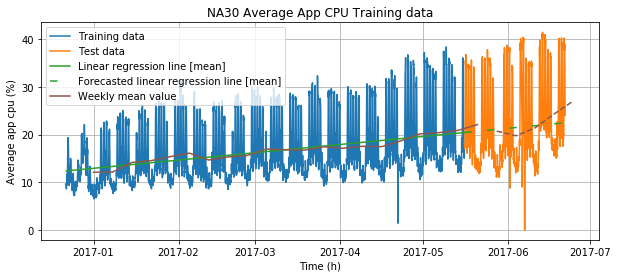

In [95]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
regr = linear_model.LinearRegression()
df_model_train['avg_app_cpu'].values.shape
linear_model=regr.fit((df_model_train['indices'].values).reshape(-1, 1), (df_model_train['avg_app_cpu'].values).reshape(-1, 1))
print((linear_model.intercept_[0], linear_model.coef_[0]))

df_temp=df_model_train.copy(deep=True)
df_temp.set_index('Timestamp',inplace=True)
df_model_train_mean=df_temp['avg_app_cpu'].groupby(pd.TimeGrouper(freq='W')).mean()

df_temp=df_model_test.copy(deep=True)
df_temp.set_index('Timestamp',inplace=True)
df_model_test_mean=df_temp['avg_app_cpu'].groupby(pd.TimeGrouper(freq='W')).mean()

x_start_mean_line=df_model_train.iloc[0]['Timestamp']
x_end_mean_line=df_model_train.iloc[(len(df_model_train)-1)]['Timestamp']
y_start_mean_line=linear_model.intercept_[0]+linear_model.coef_[0]*df_model_train.iloc[0]['indices']
y_end_mean_line=linear_model.intercept_[0]+linear_model.coef_[0]*df_model_train.iloc[(len(df_model_train)-1)]['indices']
x_forecast_start_mean_line=df_model_test.iloc[0]['Timestamp']
x_forecast_end_mean_line=df_model_test.iloc[(len(df_model_test)-1)]['Timestamp']
y_forecast_start_mean_line=linear_model.intercept_[0]+linear_model.coef_[0]*df_model_test.iloc[0]['indices']
y_forecast_end_mean_line=linear_model.intercept_[0]+linear_model.coef_[0]*df_model_test.iloc[(len(df_model_test)-1)]['indices']

plt.plot(df_model_train['Timestamp'],df_model_train['avg_app_cpu'],c='#1f77b4')
plt.plot(df_model_test['Timestamp'],df_model_test['avg_app_cpu'],c='#ff7f0e')
plt.plot([x_start_mean_line,x_end_mean_line],[y_start_mean_line,y_end_mean_line],c='#2ca02c')
plt.plot([x_forecast_start_mean_line,x_forecast_end_mean_line],[y_forecast_start_mean_line,y_forecast_end_mean_line],c='#2ca02c', linestyle='--', dashes=(5, 10))
plt.plot(df_model_train_mean.index.values[1:],df_model_train_mean[1:],c='#8c564b')
plt.plot(df_model_test_mean.index.values[1:],df_model_test_mean[1:],c='#8c564b', linestyle='--')
plt.title('NA30 Average App CPU Training data')
plt.xlabel('Time (h)')
plt.ylabel('Average app cpu (%)')
plt.legend(['Training data','Test data','Linear regression line [mean]','Forecasted linear regression line [mean]','Weekly mean value'])
plt.grid(True)
plt.show()

Let's see the errors for linear regression

In [96]:
df_model_train_mean_df = pd.DataFrame(df_model_train_mean)
df_model_train_mean_df.reset_index(level=0, inplace=True)
df_model_train_mean_df=df_model_train_mean_df.iloc[1:len(df_model_train_mean_df)]

df_model_train_mean_df['indices'] = (df_model_train_mean_df['Timestamp']-df_model_train['Timestamp'].iloc[0]).astype('timedelta64[h]')
df_model_train_mean_df['avg_app_cpu_pred']=linear_model.intercept_[0]+linear_model.coef_[0]*df_model_train_mean_df['indices']
MAE_train=(1/len(df_model_train_mean_df))*np.sum(np.abs(df_model_train_mean_df['avg_app_cpu_pred']-df_model_train_mean_df['avg_app_cpu']))
MAPE_train=(100/len(df_model_train_mean_df))*np.sum(np.abs(df_model_train_mean_df['avg_app_cpu_pred']-df_model_train_mean_df['avg_app_cpu'])/df_model_train_mean_df['avg_app_cpu'])


df_model_test_mean_df = pd.DataFrame(df_model_test_mean)
df_model_test_mean_df.reset_index(level=0, inplace=True)
df_model_test_mean_df=df_model_test_mean_df.iloc[1:len(df_model_test_mean_df)]

df_model_test_mean_df['indices'] = (df_model_test_mean_df['Timestamp']-df_model_train['Timestamp'].iloc[0]).astype('timedelta64[h]')
df_model_test_mean_df['avg_app_cpu_pred']=linear_model.intercept_[0]+linear_model.coef_[0]*df_model_test_mean_df['indices']
MAE_test=(1/len(df_model_test_mean_df))*np.sum(np.abs(df_model_test_mean_df['avg_app_cpu_pred']-df_model_test_mean_df['avg_app_cpu']))
MAPE_test=(100/len(df_model_test_mean_df))*np.sum(np.abs(df_model_test_mean_df['avg_app_cpu_pred']-df_model_test_mean_df['avg_app_cpu'])/df_model_test_mean_df['avg_app_cpu'])

print('MAE for train set: ' + str(np.round(MAE_train, decimals=2)) + '% app cpu')
print('MAE for test set: ' + str(np.round(MAE_test, decimals=2)) + '% app cpu')
print('MAPE for train set: ' + str(np.round(MAPE_train, decimals=2))+'% of % app cpu')
print('MAPE for test set: ' + str(np.round(MAPE_test, decimals=2))+'% of % app cpu')

MAE for train set: 0.67% app cpu
MAE for test set: 1.81% app cpu
MAPE for train set: 4.1% of % app cpu
MAPE for test set: 7.49% of % app cpu


In [98]:
#Read apt and transactions
file_name='agg_business_pod_hourly.csv'
df_bus=pd.read_csv(data_dir+file_name, header=None, na_values=[r'\N'])
df_bus.columns = ['hour_key','date_key','datacenter','superpod','pod','avg_apt','total_transactions','users_per_hour','last_modified','release_count']
df_bus['hour_key']=df_bus['hour_key'].astype('str')
df_bus['date_key']=df_bus['date_key'].astype('str')
df_bus['hour_date']=df_bus['date_key']+ " " + df_bus["hour_key"] + ":00"
df_timestamp = [dateutil.parser.parse(a) for a in df_bus['hour_date'].tolist()]
df_bus['Timestamp'] = df_timestamp

#The columns you want here are hour_key, date_key, datacenter, superpod, pod, avg_apt and total_transactions



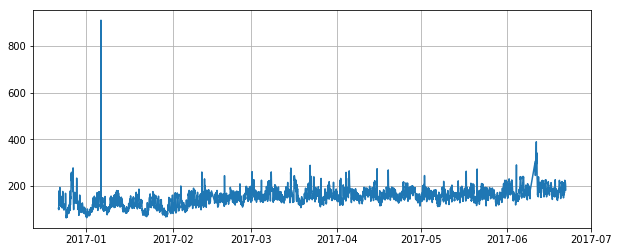

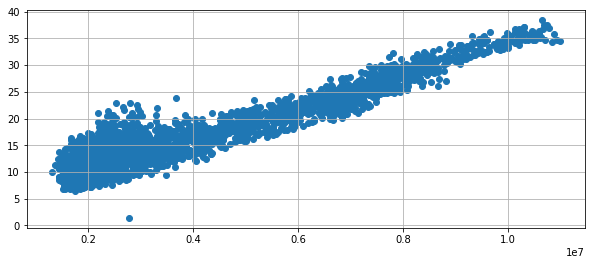

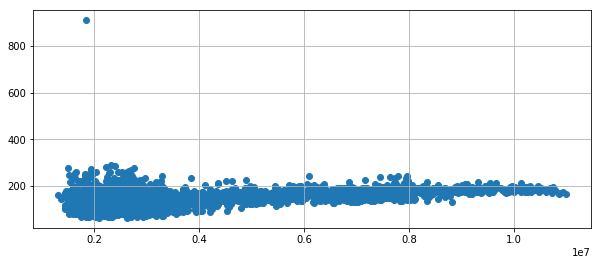

In [99]:
from scipy import stats
from sklearn import preprocessing
interested_pod="na30"
mask = (df_bus['pod'] == interested_pod)
df_bus_model = df_bus.loc[mask]
mask = (df_bus_model['Timestamp'] < dateutil.parser.parse('2017-6-22')) & (df_bus_model['Timestamp'] > dateutil.parser.parse('2016-12-22'))
df_bus_model = df_bus_model.loc[mask]
df_bus_model=df_bus_model.sort_values(by=['Timestamp'])

plt.plot(df_bus_model['Timestamp'],df_bus_model['avg_apt'],c='#1f77b4')
plt.grid()
plt.show()

df_bus_model_mrg = df_bus_model[['Timestamp','datacenter','superpod','pod','avg_apt','total_transactions']]
df_app_model_mrg = df_model[['Timestamp','datacenter','superpod','pod','avg_app_cpu']]
df_model_mrg = pd.merge(df_app_model_mrg,df_bus_model_mrg,how='inner',left_on=['Timestamp','datacenter','superpod','pod'],right_on=['Timestamp','datacenter','superpod','pod'])

plt.scatter(df_model_mrg['total_transactions'],df_model_mrg['avg_app_cpu'],c='#1f77b4')#
plt.grid()
plt.show()
plt.scatter(df_model_mrg['total_transactions'],df_model_mrg['avg_apt'],c='#1f77b4')#
plt.grid()
plt.show()


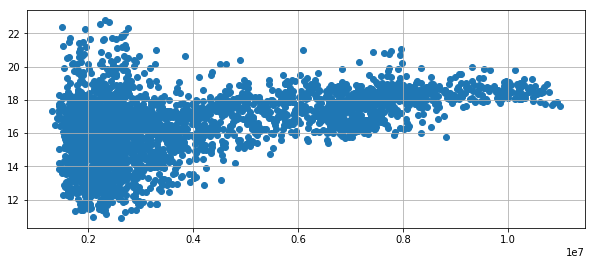

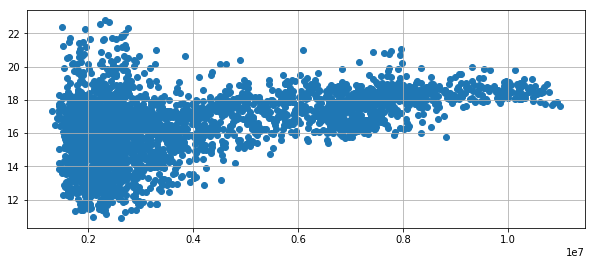

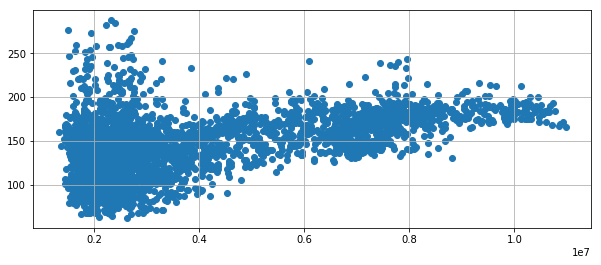

In [100]:
q=stats.boxcox(df_model_mrg['avg_apt'])
df_model_mrg['avg_apt_transformed']=q[0]

df_model_mrg['avg_apt_transformed2']=np.log1p(df_model_mrg['avg_apt'])
#Let's remove the outlier to see the correlation more clearly
mask = (df_model_mrg['avg_apt_transformed'] < 25)
df_model_mrg = df_model_mrg.loc[mask]

plt.scatter(df_model_mrg['total_transactions'],df_model_mrg['avg_apt_transformed'],c='#1f77b4')#
plt.grid()
plt.show()
#APTBoxCox = preprocessing.scale(stats.boxcox(df_model_mrg['avg_apt']))
#type(APTBoxCox)


plt.scatter(df_model_mrg['total_transactions'],df_model_mrg['avg_apt_transformed'],c='#1f77b4')#
plt.grid()
plt.show()

plt.scatter(df_model_mrg['total_transactions'],df_model_mrg['avg_apt'],c='#1f77b4')#
plt.grid()
plt.show()

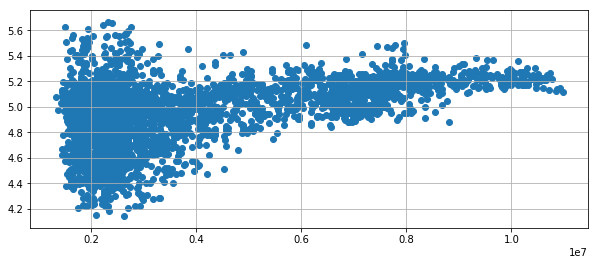

In [101]:
df_model_mrg['avg_apt_transformed2']=np.log1p(df_model_mrg['avg_apt'])
plt.scatter(df_model_mrg['total_transactions'],df_model_mrg['avg_apt_transformed2'],c='#1f77b4')#
plt.grid()
plt.show()

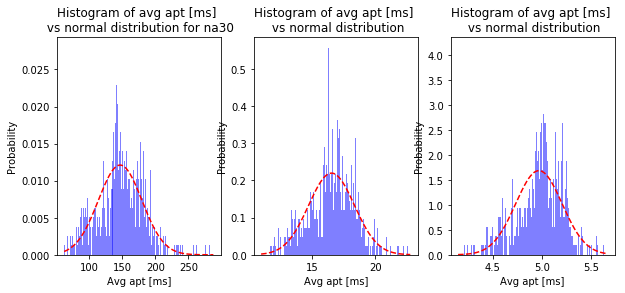

In [102]:
fig, axes = plt.subplots(nrows=1, ncols=3)
ax0, ax1, ax2 = axes.flatten()
n, bins, patches = ax0.hist(df_model_mrg['avg_apt'].dropna(),1000,normed=1, facecolor='blue', alpha=0.5)#, 100, normed=1, facecolor='blue', alpha=0.5
mu = np.mean(df_model_mrg['avg_apt'].dropna())
sigma = np.std(df_model_mrg['avg_apt'].dropna())
y = mlab.normpdf(bins, mu, sigma)
#plt.subplot(1, 2, 1)
ax0.plot(bins, y, 'r--')
ax0.set_xlabel('Avg apt [ms]')
ax0.set_ylabel('Probability')
ax0.set_title('Histogram of avg apt [ms] \n vs normal distribution for '+interested_pod)
#plt.show()
n, bins, patches = ax1.hist(df_model_mrg['avg_apt_transformed'].dropna(),1000,normed=1, facecolor='blue', alpha=0.5)#, 100, normed=1, facecolor='blue', alpha=0.5
mu = np.mean(df_model_mrg['avg_apt_transformed'].dropna())
sigma = np.std(df_model_mrg['avg_apt_transformed'].dropna())
y = mlab.normpdf(bins, mu, sigma)
#plt.subplot(1, 2, 2)
ax1.plot(bins, y, 'r--')
ax1.set_xlabel('Avg apt [ms]')
ax1.set_ylabel('Probability')
ax1.set_title('Histogram of avg apt [ms] \n vs normal distribution')

n, bins, patches = ax2.hist(df_model_mrg['avg_apt_transformed2'].dropna(),1000,normed=1, facecolor='blue', alpha=0.5)#, 100, normed=1, facecolor='blue', alpha=0.5
mu = np.mean(df_model_mrg['avg_apt_transformed2'].dropna())
sigma = np.std(df_model_mrg['avg_apt_transformed2'].dropna())
y = mlab.normpdf(bins, mu, sigma)
#plt.subplot(1, 2, 2)
ax2.plot(bins, y, 'r--')
ax2.set_xlabel('Avg apt [ms]')
ax2.set_ylabel('Probability')
ax2.set_title('Histogram of avg apt [ms] \n vs normal distribution')
plt.show()

In [109]:
#Read db size data
file_name='agg_database_daily.csv'
df=pd.read_csv(data_dir+file_name, header=None, na_values=[r'\N'])
df.columns = ['date_key','datacenter','superpod','pod','max_redo_size','max_active_sessions','max_db_cpu_user','max_peak_buffer','avg_db_cpu_\
system','avg_db_cpu_user','total_db_size_in_tb','used_db_space_in_tb','free_db_space_in_tb','asm_free_db_space_in_tb','asm_used_db_space_in_t\
b','asm_total_db_size_in_tb','last_modified','asm_used_db_space_perc','oem_cpu_util','oem_read_io_latency']

#The columns you want here are date_key, datacenter, superpod, pod and asm_used_db_space_in_tb
df['date_key']=df['date_key'].astype('str')
df_timestamp = [dateutil.parser.parse(a) for a in df['date_key'].tolist()]
df['Timestamp'] = df_timestamp
#df_timestamp[0:5]

Let's look at an example of a low variability metric that has frequent changes in its slope.

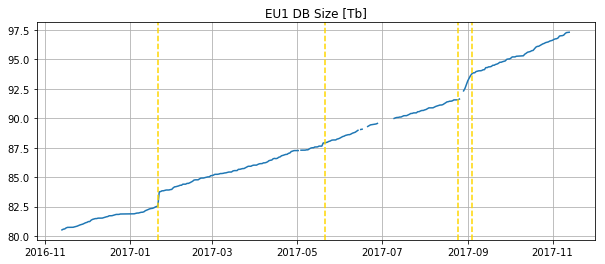

In [125]:
interested_pod="eu1"
mask = (df['pod'] == interested_pod)
df_model = df.loc[mask]
mask= (df_model['Timestamp'] < dateutil.parser.parse('2017-12-12')) & (df_model['Timestamp'] > dateutil.parser.parse('2016-11-12'))
df_model = df_model[mask]
df_model=df_model.sort_values(by=['Timestamp'])


fig, axes = plt.subplots(nrows=1, ncols=1)
#ax0 = axes.flatten()
axes.plot(df_model['Timestamp'],df_model['asm_used_db_space_in_tb'])
axes.axvline(x=dateutil.parser.parse('2017-09-04'),ymin=0,ymax=1,linestyle='--',c='gold')
axes.axvline(x=dateutil.parser.parse('2017-08-25'),ymin=0,ymax=1,linestyle='--',c='gold')
axes.axvline(x=dateutil.parser.parse('2017-05-21'),ymin=0,ymax=1,linestyle='--',c='gold')
axes.axvline(x=dateutil.parser.parse('2017-01-21'),ymin=0,ymax=1,linestyle='--',c='gold')
plt.title('EU1 DB Size [Tb]')
plt.grid(True)
plt.show()